# Wind Turbine Power Production
###  Project assessment
#### [Machine Learning and Statistics Module GMIT 2020 ]

---

<img align="left" width="300" src="https://image.flaticon.com/icons/png/512/1778/1778210.png">
<br>

<br>

Lecturer: *Ian McLoughlin (https://github.com/ianmcloughlin)*

Completed by: *Olga Rozhdestvina (G00387844@gmit.ie)*

---

## Table of Contents

* [Overview](#overview)
* [General Setup](#setup)
* [Loading Data](#loading_data)
* [](#)
* [](#)
* [](#)
* [](#)

<br>

### Overview <a name="overview"></a>
___

<br>

### General Setup <a name="setup"></a>
___

In [1]:
# Neural networks.
import tensorflow.keras as kr

# Numerical arrays.
import numpy as np

# Data frames.
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt
# Another package for plotting.
import seaborn as sns

%matplotlib inline

In [2]:
# Theme for plots.
sns.set_theme(palette="Set2", context="paper", font_scale=1.5, )

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

<br>

### Loading Data <a name="loading_data"></a>
___

> [1] [Adjusting Size of Seaborn Plot](https://stackoverflow.com/questions/51502927/adjusting-size-of-seaborn-plot)

In [3]:
# Load the iris data set from a URL.
df = pd.read_csv("powerproduction.txt")

# Display the data frame.
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


In [4]:
# Check for empty values.
df.isnull().values.any()

False

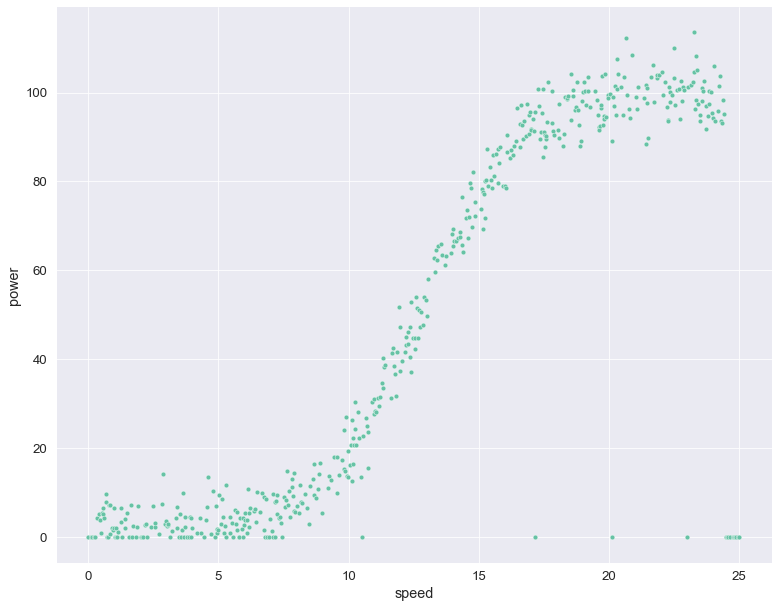

In [5]:
# Plot data.
sns.relplot(data=df, x="speed", y="power")

# Change plot size.
fig = plt.gcf()
fig.set_size_inches(12, 9)

# Show the plot.
plt.show()

The above plot shows that the relationship between Power and Speed predominantly follows "S"-shaped curve or sigmoid curve. 